In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import random
import os

import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import random
from tqdm.notebook import tqdm
import numpy as np
import copy

from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Download and load the entire dataset
train_dataset = torchvision.datasets.Flowers102(
    root='./data',  # Set your dataset directory
    split='train',
    download=True
)

val_dataset = torchvision.datasets.Flowers102(
    root='./data',  # Set your dataset directory
    split='val',
    download=True
)

# Create a DataLoader for the test dataset
test_dataset = torchvision.datasets.Flowers102(
    root='./data',
    split='test',
    download=True
)

In [3]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Step 1: Select One sample from each class

In [4]:
samples_train = {}
samples_val = {}
samples_test = {}

for data in tqdm(train_dataset, leave=False):
    if data[1] not in samples_train:
        samples_train[data[1]] = [data[0]]
    else:
        samples_train[data[1]].append(data[0])
        
for data in tqdm(val_dataset, leave=False):
    if data[1] not in samples_val:
        samples_val[data[1]] = [data[0]]
    else:
        samples_val[data[1]].append(data[0])
        
for data in tqdm(test_dataset, leave=False):
    if data[1] not in samples_test:
        samples_test[data[1]] = [data[0]]
    else:
        samples_test[data[1]].append(data[0])

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/6149 [00:00<?, ?it/s]

In [5]:
for key in samples_train:
    samples_train[key] = random.sample(samples_train[key], 5)

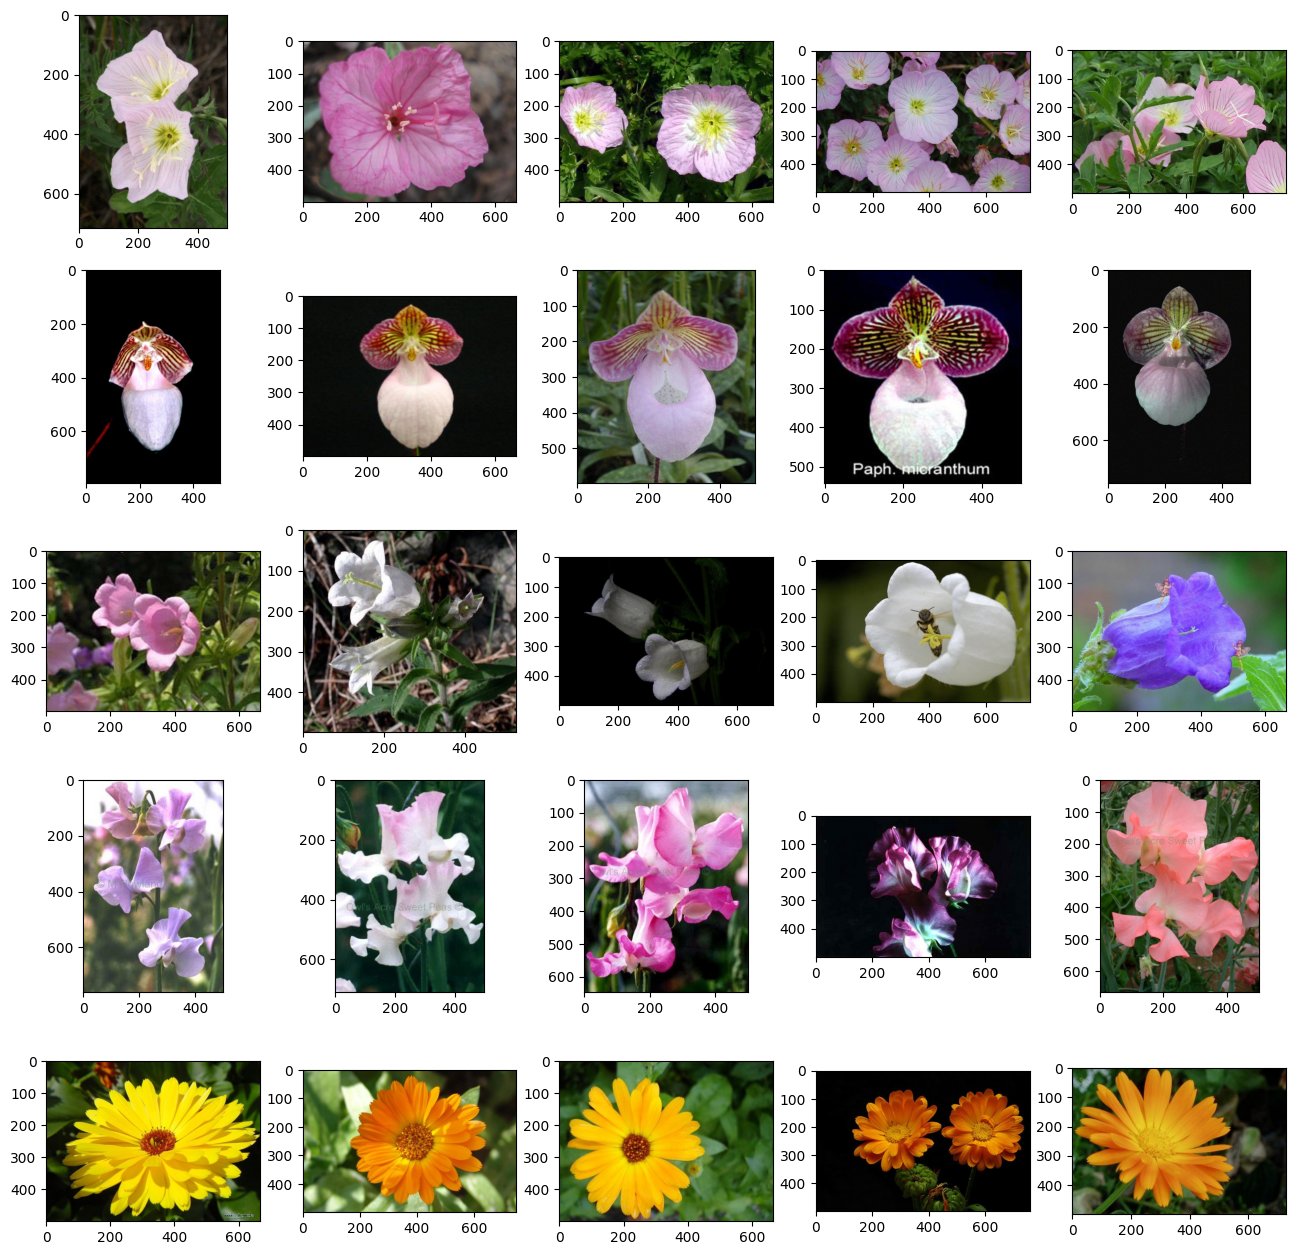

In [6]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(5, 5, figsize=(16,16))

for i in range(5):
    ax[i,0].imshow(samples_train[i][0])
    ax[i,1].imshow(samples_train[i][1])    
    ax[i,2].imshow(samples_train[i][2])    
    ax[i,3].imshow(samples_train[i][3])   
    ax[i,4].imshow(samples_train[i][4])    

### Step 2: Define Siamese Network Architecture

Using the mobilenet as a backbone for our siamese network and with embeddings of size 64

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Initialize base network
        self.base_network = initialize_base_network()

    def forward_one(self, x):
        # Forward pass for one branch
        x = self.base_network(x)
        return x

    def forward(self, input1, input2):
        # Forward pass for both branches
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

def initialize_base_network():
    # Initialize base network (MobileNetV2 in this case)
    base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

    # Modify base_model to remove the final fully connected layer
    base_model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1280, 64)  # Adjust the output size based on your needs
    )


    # Freeze layers
    for param in base_model.features.parameters():
        param.requires_grad = False

    return base_model

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, y_true, y_pred):
        square_pred = torch.square(y_pred)
        margin_square = torch.square(F.relu(self.margin - y_pred))
        return (y_true * square_pred + (1 - y_true) * margin_square).mean()

### Step 3: Train Siamese Network on samples

In [8]:
# Custom dataset for Siamese network
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.convert_dataset(dataset)
        self.transform = transform
    
    def convert_dataset(self, dataset):
        alist = []
        for key in dataset:
            for items in dataset[key]:
                alist.append((items, key))
        return alist
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        anchor, anchor_label = self.dataset[index]

        should_get_same_class = random.randint(0, 1)  # 50% chance of getting a positive pair

        if should_get_same_class:
            while True:
                pos_index = random.randint(0, len(self.dataset) - 1)
                pos, pos_label = self.dataset[pos_index]
                if anchor_label == pos_label:
                    break
        else:
            while True:
                neg_index = random.randint(0, len(self.dataset) - 1)
                neg, neg_label = self.dataset[neg_index]
                if anchor_label != neg_label:
                    break
        if self.transform:
            anchor = self.transform(anchor)
            if should_get_same_class:
                pos = self.transform(pos)
                return anchor, pos, torch.tensor(should_get_same_class, dtype=torch.float32), anchor_label
            else:
                neg = self.transform(neg)
                return anchor, neg, torch.tensor(should_get_same_class, dtype=torch.float32), anchor_label

In [9]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_siamese_dataset = SiameseDataset(samples_train, transform=train_transforms)
val_siamese_dataset = SiameseDataset(samples_val, transform=test_transforms)
test_siamese_dataset = SiameseDataset(samples_test, transform=test_transforms)


train_siamese_loader = DataLoader(train_siamese_dataset, batch_size=64, shuffle=True)
val_siamese_loader = DataLoader(val_siamese_dataset, batch_size=64, shuffle=False)
test_siamese_loader = DataLoader(test_siamese_dataset, batch_size=64, shuffle=False)

In [10]:
device='cuda'

# Hyperparameters
learning_rate = 0.001

# Initialize the Siamese network
siamese_net = SiameseNetwork().to(device)

# Define a loss function and optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

es = EarlyStopper(patience=8)
# print(siamese_net)

In [11]:
num_epochs = 200

training_loss = []
validation_loss = []

best_model_wts = copy.deepcopy(siamese_net.state_dict())
lowest_val_loss = np.inf

for epoch in tqdm(range(num_epochs), desc = 'Epoch'):
    # Training
    siamese_net.train()
    total_loss = 0.0

    for batch in tqdm(train_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Training", leave=False):
        input1, input2, labels, _ = batch
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

        optimizer.zero_grad()
        output1, output2 = siamese_net(input1, input2)
        
        distance = torch.pairwise_distance(output1, output2)
        
        
        loss = criterion(labels, distance)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_siamese_loader)
    
    training_loss.append(avg_loss)

    # Validation (optional)
    siamese_net.eval()
    with torch.no_grad():
        val_loss = 0.0

        for batch in tqdm(val_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Validation", leave=False):
            input1, input2, labels, _ = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = siamese_net(input1, input2)
            
            distance = torch.pairwise_distance(output1, output2)
            
            loss = criterion(labels, distance)

            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_siamese_loader)
        
        validation_loss.append(avg_val_loss)
    
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model_wts = copy.deepcopy(siamese_net.state_dict())
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss} Val Loss: {avg_val_loss}")
    
    if es.early_stop(avg_val_loss):
        print("Stopping Early")
        break

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/200 - Train Loss: 0.9179259613156319 Val Loss: 0.7629806101322174


Epoch 2/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/200 - Train Loss: 0.7191178500652313 Val Loss: 0.6356523036956787


Epoch 3/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/200 - Train Loss: 0.6478923223912716 Val Loss: 0.5518713444471359


Epoch 4/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/200 - Train Loss: 0.5381430722773075 Val Loss: 0.4847082495689392


Epoch 5/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/200 - Train Loss: 0.4755159430205822 Val Loss: 0.4070442523807287


Epoch 6/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/200 - Train Loss: 0.43797334656119347 Val Loss: 0.39064729772508144


Epoch 7/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/200 - Train Loss: 0.34549057483673096 Val Loss: 0.3209583619609475


Epoch 8/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/200 - Train Loss: 0.4039313681423664 Val Loss: 0.31742127053439617


Epoch 9/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/200 - Train Loss: 0.3256368935108185 Val Loss: 0.3184843435883522


Epoch 10/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/200 - Train Loss: 0.31716926395893097 Val Loss: 0.3146406449377537


Epoch 11/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/200 - Train Loss: 0.2958861105144024 Val Loss: 0.2955223750323057


Epoch 12/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/200 - Train Loss: 0.2868681959807873 Val Loss: 0.27576608676463366


Epoch 13/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/200 - Train Loss: 0.29383062198758125 Val Loss: 0.2625543838366866


Epoch 14/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/200 - Train Loss: 0.2731960713863373 Val Loss: 0.24418290331959724


Epoch 15/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/200 - Train Loss: 0.2610450889915228 Val Loss: 0.24644226767122746


Epoch 16/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/200 - Train Loss: 0.2561520766466856 Val Loss: 0.25472474563866854


Epoch 17/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/200 - Train Loss: 0.25909771025180817 Val Loss: 0.22785122226923704


Epoch 18/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/200 - Train Loss: 0.24048656038939953 Val Loss: 0.22607495822012424


Epoch 19/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/200 - Train Loss: 0.24098424054682255 Val Loss: 0.21807473804801702


Epoch 20/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/200 - Train Loss: 0.2213958278298378 Val Loss: 0.2361502582207322


Epoch 21/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/200 - Train Loss: 0.22931148298084736 Val Loss: 0.22074273508042097


Epoch 22/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/200 - Train Loss: 0.23483861610293388 Val Loss: 0.21047588530927896


Epoch 23/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/200 - Train Loss: 0.21812747791409492 Val Loss: 0.21597479563206434


Epoch 24/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/200 - Train Loss: 0.21950273402035236 Val Loss: 0.20883227698504925


Epoch 25/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/200 - Train Loss: 0.2225288599729538 Val Loss: 0.2137632519006729


Epoch 26/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/200 - Train Loss: 0.22388166934251785 Val Loss: 0.21459924057126045


Epoch 27/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/200 - Train Loss: 0.22113934345543385 Val Loss: 0.2118866667151451


Epoch 28/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/200 - Train Loss: 0.23154961690306664 Val Loss: 0.2030523158609867


Epoch 29/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/200 - Train Loss: 0.2095816396176815 Val Loss: 0.2098501669242978


Epoch 30/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/200 - Train Loss: 0.20187652483582497 Val Loss: 0.20609869994223118


Epoch 31/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/200 - Train Loss: 0.21199634857475758 Val Loss: 0.19873992633074522


Epoch 32/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/200 - Train Loss: 0.22072564251720905 Val Loss: 0.20186510309576988


Epoch 33/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/200 - Train Loss: 0.21132168173789978 Val Loss: 0.2027363795787096


Epoch 34/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/200 - Train Loss: 0.2239279616624117 Val Loss: 0.20095512829720974


Epoch 35/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/200 - Train Loss: 0.2055458202958107 Val Loss: 0.18970296997576952


Epoch 36/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/200 - Train Loss: 0.19535356760025024 Val Loss: 0.18044412462040782


Epoch 37/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/200 - Train Loss: 0.19138475880026817 Val Loss: 0.18907385226339102


Epoch 38/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/200 - Train Loss: 0.2057400867342949 Val Loss: 0.18822271097451448


Epoch 39/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39/200 - Train Loss: 0.1985535081475973 Val Loss: 0.18956770282238722


Epoch 40/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/200 - Train Loss: 0.20799792930483818 Val Loss: 0.18994972575455904


Epoch 41/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/200 - Train Loss: 0.19793389551341534 Val Loss: 0.19625494722276926


Epoch 42/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/200 - Train Loss: 0.1915266402065754 Val Loss: 0.18761471565812826


Epoch 43/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/200 - Train Loss: 0.21083658933639526 Val Loss: 0.19031546544283628


Epoch 44/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/200 - Train Loss: 0.18985116854310036 Val Loss: 0.20338483620435
Stopping Early


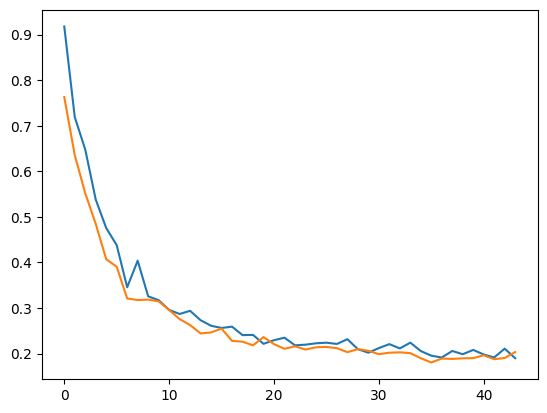

In [12]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()

In [13]:
siamese_net.load_state_dict(best_model_wts)

<All keys matched successfully>

###### Fine Tuning K Shot Model

In [14]:
# Hyperparameters
learning_rate = 0.0001

# Define a loss function and optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

es = EarlyStopper(patience=8)
# print(siamese_net)

In [15]:
# Unfreezeing the last 2 layers of mobilenet features extractor
for param in siamese_net.base_network.features[17:].parameters():
    param.requires_grad = True

In [16]:
lowest_val_loss = np.inf

for epoch in tqdm(range(num_epochs), desc = 'Epoch'):
    # Training
    siamese_net.train()
    total_loss = 0.0

    for batch in tqdm(train_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Training", leave=False):
        input1, input2, labels, _ = batch
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

        optimizer.zero_grad()
        output1, output2 = siamese_net(input1, input2)
        
        distance = torch.pairwise_distance(output1, output2)
        
        
        loss = criterion(labels, distance)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_siamese_loader)
    
    training_loss.append(avg_loss)

    # Validation (optional)
    siamese_net.eval()
    with torch.no_grad():
        val_loss = 0.0

        for batch in tqdm(val_siamese_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Validation", leave=False):
            input1, input2, labels, _ = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = siamese_net(input1, input2)
            
            distance = torch.pairwise_distance(output1, output2)
            
            loss = criterion(labels, distance)

            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_siamese_loader)
        
        validation_loss.append(avg_val_loss)
    
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model_wts = copy.deepcopy(siamese_net.state_dict())
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss} Val Loss: {avg_val_loss}")
    
    if es.early_stop(avg_val_loss):
        print("Stopping Early")
        break

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/200 - Train Loss: 0.21286144852638245 Val Loss: 0.19142142590135336


Epoch 2/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/200 - Train Loss: 0.18594743497669697 Val Loss: 0.1877861963585019


Epoch 3/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/200 - Train Loss: 0.18485278822481632 Val Loss: 0.18377986922860146


Epoch 4/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/200 - Train Loss: 0.18833108060061932 Val Loss: 0.1846758322790265


Epoch 5/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/200 - Train Loss: 0.17864258587360382 Val Loss: 0.17896807752549648


Epoch 6/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/200 - Train Loss: 0.17828995175659657 Val Loss: 0.17588142305612564


Epoch 7/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/200 - Train Loss: 0.17798933014273643 Val Loss: 0.17618863377720118


Epoch 8/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/200 - Train Loss: 0.1730384510010481 Val Loss: 0.17905142903327942


Epoch 9/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/200 - Train Loss: 0.1697606649249792 Val Loss: 0.16959503758698702


Epoch 10/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/200 - Train Loss: 0.1665994878858328 Val Loss: 0.16304205916821957


Epoch 11/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/200 - Train Loss: 0.1575141455978155 Val Loss: 0.1627775738015771


Epoch 12/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/200 - Train Loss: 0.16184048913419247 Val Loss: 0.16307984571903944


Epoch 13/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/200 - Train Loss: 0.1539630237966776 Val Loss: 0.1583708100952208


Epoch 14/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/200 - Train Loss: 0.16042188555002213 Val Loss: 0.16401667892932892


Epoch 15/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/200 - Train Loss: 0.16156025603413582 Val Loss: 0.1634063385426998


Epoch 16/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/200 - Train Loss: 0.15075990557670593 Val Loss: 0.16068664100021124


Epoch 17/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/200 - Train Loss: 0.1559278927743435 Val Loss: 0.16698331013321877


Epoch 18/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/200 - Train Loss: 0.15110402181744576 Val Loss: 0.15739399567246437


Epoch 19/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/200 - Train Loss: 0.1542099565267563 Val Loss: 0.15678281523287296


Epoch 20/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/200 - Train Loss: 0.1487952284514904 Val Loss: 0.15442824643105268


Epoch 21/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/200 - Train Loss: 0.15002494864165783 Val Loss: 0.15511086490005255


Epoch 22/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/200 - Train Loss: 0.14223398081958294 Val Loss: 0.15287353936582804


Epoch 23/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/200 - Train Loss: 0.14509735256433487 Val Loss: 0.15096202678978443


Epoch 24/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/200 - Train Loss: 0.14588716626167297 Val Loss: 0.15496046096086502


Epoch 25/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/200 - Train Loss: 0.1433777417987585 Val Loss: 0.15062437253072858


Epoch 26/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/200 - Train Loss: 0.14459765702486038 Val Loss: 0.14937517512589693


Epoch 27/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/200 - Train Loss: 0.14653032273054123 Val Loss: 0.1457807756960392


Epoch 28/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/200 - Train Loss: 0.14649826474487782 Val Loss: 0.14590690471231937


Epoch 29/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/200 - Train Loss: 0.136707853525877 Val Loss: 0.14642252307385206


Epoch 30/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/200 - Train Loss: 0.13334314431995153 Val Loss: 0.15043563023209572


Epoch 31/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/200 - Train Loss: 0.13433255814015865 Val Loss: 0.1445669187232852


Epoch 32/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/200 - Train Loss: 0.14487062394618988 Val Loss: 0.14921063836663961


Epoch 33/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/200 - Train Loss: 0.13553863856941462 Val Loss: 0.1458667293190956


Epoch 34/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/200 - Train Loss: 0.13090077135711908 Val Loss: 0.14008149970322847


Epoch 35/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/200 - Train Loss: 0.13523354195058346 Val Loss: 0.14543990837410092


Epoch 36/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/200 - Train Loss: 0.14187418296933174 Val Loss: 0.14961421489715576


Epoch 37/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/200 - Train Loss: 0.12632830254733562 Val Loss: 0.1373234959319234


Epoch 38/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/200 - Train Loss: 0.13078374695032835 Val Loss: 0.13677566358819604


Epoch 39/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39/200 - Train Loss: 0.12830269895493984 Val Loss: 0.141967729665339


Epoch 40/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/200 - Train Loss: 0.13537829648703337 Val Loss: 0.13938411371782422


Epoch 41/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/200 - Train Loss: 0.13018795754760504 Val Loss: 0.1412606961093843


Epoch 42/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/200 - Train Loss: 0.12522181030362844 Val Loss: 0.14462081575766206


Epoch 43/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/200 - Train Loss: 0.12302754074335098 Val Loss: 0.14384304312989116


Epoch 44/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/200 - Train Loss: 0.13123965449631214 Val Loss: 0.1384176928550005


Epoch 45/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45/200 - Train Loss: 0.12953989300876856 Val Loss: 0.1408125264570117


Epoch 46/ 200 - Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46/ 200 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46/200 - Train Loss: 0.13712871354073286 Val Loss: 0.1387909366749227
Stopping Early


In [17]:
siamese_net.load_state_dict(best_model_wts)

<All keys matched successfully>

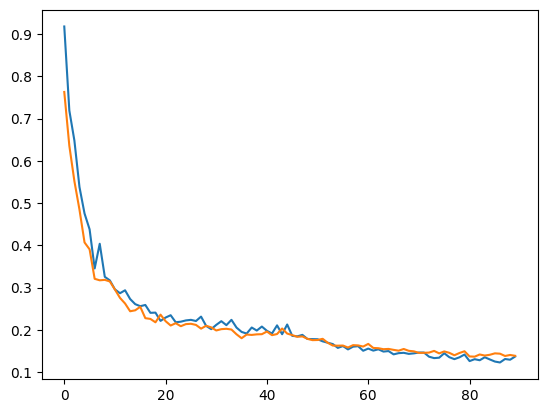

In [18]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()

### Step 4: Evaluation of Siamese Net Ability to tell similar images

###### Performance on train

In [19]:
siamese_net.eval()
train_embeddings = []
train_labels = []

true_label = []
pred_label = []

threshold=0.50
with torch.no_grad():
    for batch in tqdm(train_siamese_loader, leave=False):
            input1, input2, labels, img_class = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = siamese_net(input1, input2)
            
            binary_result = (torch.pairwise_distance(output1, output2) < threshold).float()
            
            train_embeddings+=output1.tolist()
            train_labels+=img_class.tolist()
            
            true_label += labels.tolist()
            pred_label += binary_result.tolist()

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
f1_score(true_label, pred_label)

0.860759493670886

In [21]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       257
         1.0       0.92      0.81      0.86       253

    accuracy                           0.87       510
   macro avg       0.88      0.87      0.87       510
weighted avg       0.88      0.87      0.87       510



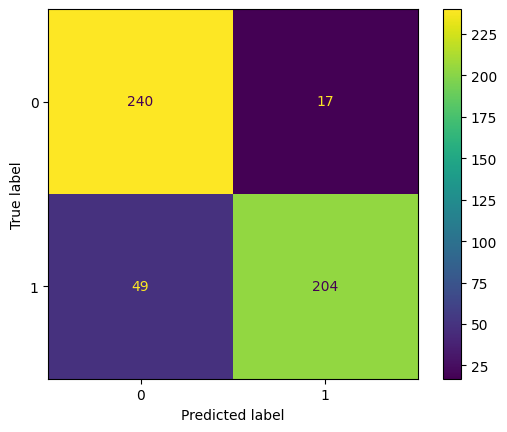

In [22]:
cm = confusion_matrix(true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

###### Performance on val

In [23]:
siamese_net.eval()
val_true_label = []
pred_label = []
threshold=0.50
with torch.no_grad():
    for batch in tqdm(val_siamese_loader, leave=False):
            input1, input2, labels, _ = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = siamese_net(input1, input2)
            
            binary_result = (torch.pairwise_distance(output1, output2) < threshold).float()
            
            val_true_label += labels.tolist()
            pred_label += binary_result.tolist()

  0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
f1_score(val_true_label, pred_label)

0.8284153005464482

In [25]:
print(classification_report(val_true_label, pred_label))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       532
         1.0       0.89      0.78      0.83       488

    accuracy                           0.85      1020
   macro avg       0.85      0.84      0.84      1020
weighted avg       0.85      0.85      0.85      1020



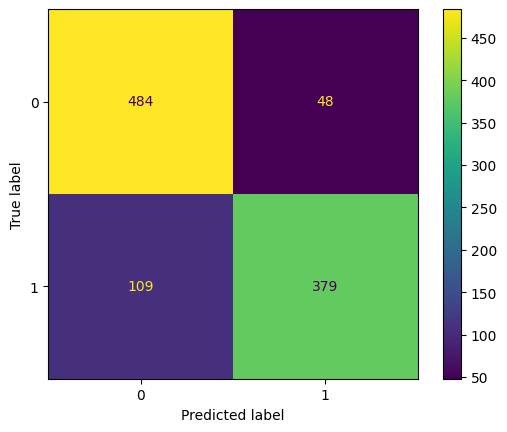

In [26]:
cm = confusion_matrix(val_true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

###### Performance on test set

In [27]:
siamese_net.eval()
test_true_label = []
pred_label = []
threshold=0.50
with torch.no_grad():
    for batch in tqdm(test_siamese_loader, leave=False):
            input1, input2, labels, _ = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, output2 = siamese_net(input1, input2)
            
            binary_result = (torch.pairwise_distance(output1, output2) < threshold).float()
            
            test_true_label += labels.tolist()
            pred_label += binary_result.tolist()

  0%|          | 0/97 [00:00<?, ?it/s]

In [28]:
f1_score(test_true_label, pred_label)

0.7912936633315781

In [29]:
print(classification_report(val_true_label, pred_label))

              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      3018
         1.0       0.88      0.72      0.79      3131

    accuracy                           0.81      6149
   macro avg       0.82      0.81      0.81      6149
weighted avg       0.82      0.81      0.81      6149



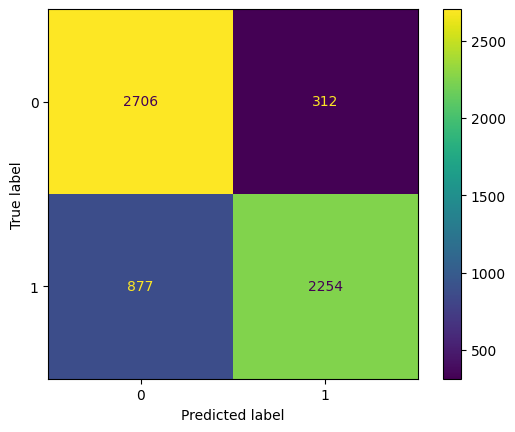

In [30]:
cm = confusion_matrix(val_true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [31]:
test_true_class = []
test_embeddings = []

threshold=0.50
with torch.no_grad():
    for batch in tqdm(test_siamese_loader, leave=False):
            input1, input2, labels, img_class = batch
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

            output1, _ = siamese_net(input1, input2)
            
#             binary_result = (torch.pairwise_distance(output1, output2) < threshold).float()
            
            test_embeddings+=output1.tolist()
            test_true_class+=img_class.tolist()

  0%|          | 0/97 [00:00<?, ?it/s]

In [32]:
pred_labels = []
for embeddings in tqdm(test_embeddings):
    closest_distance = np.inf
    best_class = -1
    distances = [0 for i in range(102)]
    for index, te in enumerate(train_embeddings):
        distances[train_labels[index]] += torch.pairwise_distance(torch.tensor(embeddings), torch.tensor(te))
    
    pred_labels.append(distances.index(min(distances)))

  0%|          | 0/6149 [00:00<?, ?it/s]

In [33]:
f1_score(test_true_class, pred_labels, average='weighted')

0.4428047728394631

In [34]:
print(classification_report(test_true_class, pred_labels))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10        20
           1       0.88      0.70      0.78        40
           2       0.14      0.15      0.14        20
           3       0.25      0.06      0.09        36
           4       0.60      0.13      0.22        45
           5       0.88      0.88      0.88        25
           6       0.19      0.55      0.28        20
           7       0.84      0.88      0.86        65
           8       0.41      0.50      0.45        26
           9       0.37      0.28      0.32        25
          10       0.71      0.15      0.25        67
          11       0.60      0.04      0.08        67
          12       0.78      0.48      0.60        29
          13       0.39      0.82      0.53        28
          14       0.55      0.76      0.64        29
          15       0.30      0.33      0.32        21
          16       0.75      0.83      0.79        65
          17       0.13    

/home/FYP/kwong040/.conda/envs/RunJupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/FYP/kwong040/.conda/envs/RunJupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/FYP/kwong040/.conda/envs/RunJupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Causes for good predictions

High F1 class: 59

In [35]:
from collections import Counter

In [43]:
errors = []
for i in range(len(test_true_class)):
    if test_true_class[i] == 59 and pred_labels[i] != 59:
        errors.append(pred_labels[i])
Counter(sorted(errors)).most_common(5)

[(41, 1), (45, 1), (49, 1), (89, 1), (99, 1)]

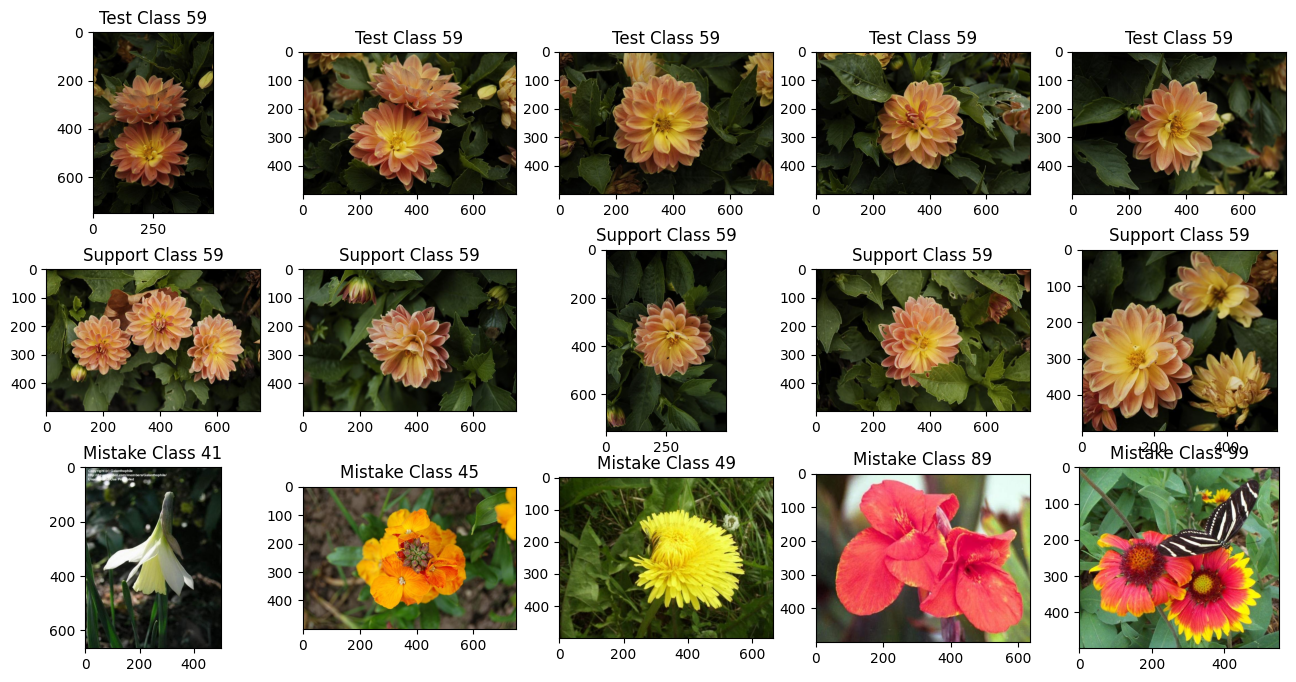

In [56]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(3, 5, figsize=(16,8))

for i in range(5):
    ax[0,i].imshow(samples_test[59][i])
    ax[0,i].title.set_text(f'Test Class 59')
    ax[1,i].imshow(samples_train[59][i])
    ax[1,i].title.set_text(f'Support Class 59')
    
ax[2,0].imshow(samples_train[41][0])
ax[2,0].title.set_text(f'Mistake Class 41')

ax[2,1].imshow(samples_train[45][0])
ax[2,1].title.set_text(f'Mistake Class 45')

ax[2,2].imshow(samples_train[49][0])
ax[2,2].title.set_text(f'Mistake Class 49')

ax[2,3].imshow(samples_train[89][0])
ax[2,3].title.set_text(f'Mistake Class 89')

ax[2,4].imshow(samples_train[99][0])
ax[2,4].title.set_text(f'Mistake Class 99')

### Causes of error

Low F1 Class: 38

In [51]:
errors = []
for i in range(len(test_true_class)):
    if test_true_class[i] == 38 and pred_labels[i] != 38:
        errors.append(pred_labels[i])
    

In [52]:
Counter(sorted(errors)).most_common(5)

[(35, 2), (77, 2), (17, 1), (19, 1), (60, 1)]

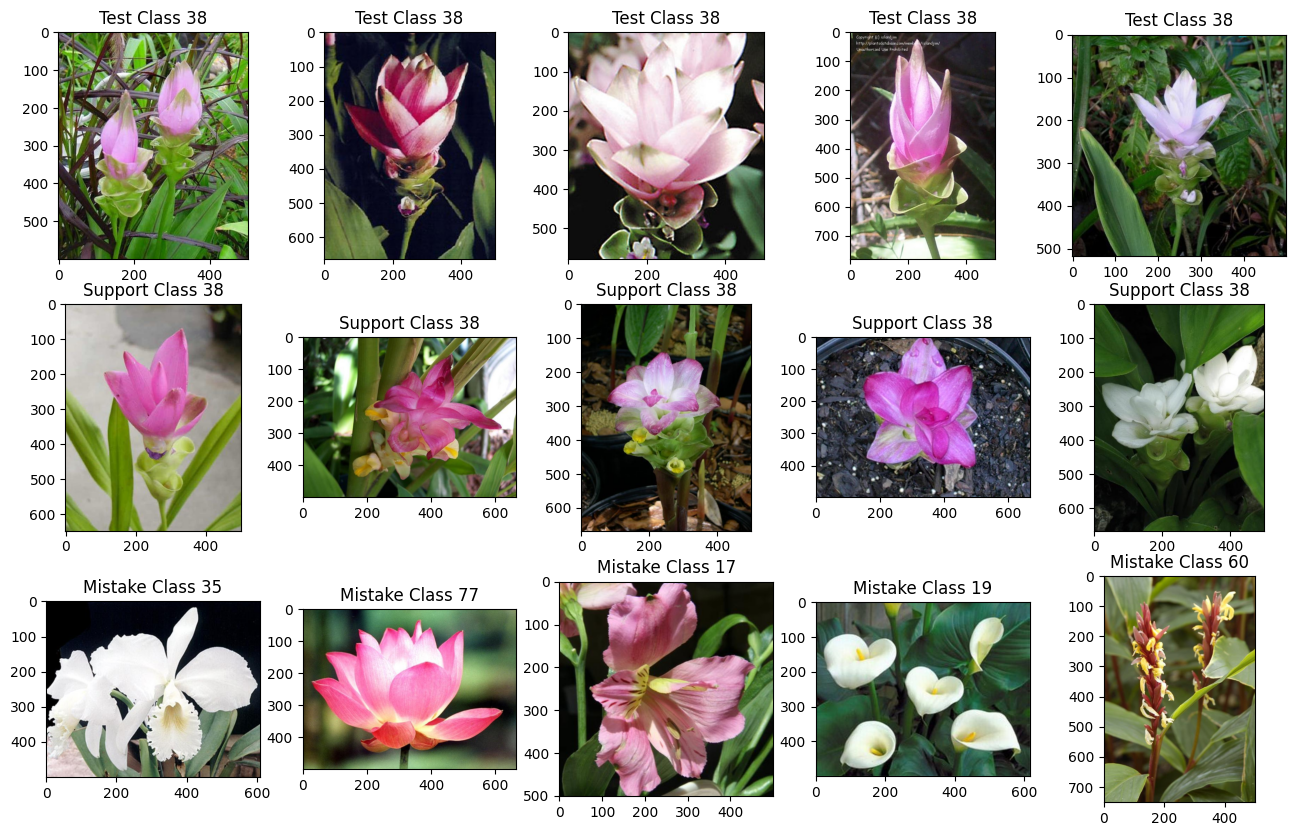

In [58]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(3, 5, figsize=(16,10))

for i in range(5):
    ax[0,i].imshow(samples_test[38][i])
    ax[0,i].title.set_text(f'Test Class 38')
    ax[1,i].imshow(samples_train[38][i])
    ax[1,i].title.set_text(f'Support Class 38')
    
    
ax[2,0].imshow(samples_train[35][0])
ax[2,0].title.set_text(f'Mistake Class 35')

ax[2,1].imshow(samples_train[77][0])
ax[2,1].title.set_text(f'Mistake Class 77')

ax[2,2].imshow(samples_train[17][0])
ax[2,2].title.set_text(f'Mistake Class 17')

ax[2,3].imshow(samples_train[19][0])
ax[2,3].title.set_text(f'Mistake Class 19')

ax[2,4].imshow(samples_train[60][0])
ax[2,4].title.set_text(f'Mistake Class 60')